In [1]:
#| hide
from model_evaluation.core import *

/grupoa/config/miniconda3/envs/ruescog_env/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# model_testing

> A library to test fastai learners using some evaluation techniques.

This library will allow you to easily evaluate your `fastai` `Learner`s using different evaluation techinique such as `KFold-validation` or `StratifiedKFold-Validation`.

## Install

To install the library, just run:

```sh
pip install model_testing
```

## How to use

This library provides a method that can help you in the process of model evaluation. Using the [scikit-learn validation techniques](https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation-iterators) you can validate your deep learning models.

In order to validate your model, you will need to build and train various versions of it (for example, using a KFold validation, it is needed to build five different models).

For doing so, you need to provide: the `DataBlock` hparams (hyperparameters), the `DataLoader` hparams, the technique used to split the data, the `Learner` construction hparams, the learning mode (whether to use a pretrained model or not: `fit_one_cycle` or `finetune`) and the `Learner` training hparams.

In [2]:
%%capture
!rm -r dataset
!unzip dataset

In [12]:
from fastai.basics import *
from fastai.vision import models
from fastai.vision.all import *
from fastai.metrics import *
from fastai.data.all import *
from fastai.callback import *

import PIL
import torchvision.transforms as transforms
from pathlib import Path
import random

from sklearn.model_selection import KFold
from model_evaluation.core import evaluate

path = Path('dataset/')
path_images = path/"Images"
path_labels = path/"Labels"
test_name = "test"

def get_y_fn(x):
    return Path(str(x).replace("Images","Labels").replace("color","gt").replace(".jpg",".png"))

codes = np.loadtxt(path/'codesAll.txt', dtype=str)

def ParentSplitter(x):
    return Path(x).parent.name==test_name

from albumentations import (
  Compose,
  OneOf,
  ElasticTransform,
  GridDistortion, 
  OpticalDistortion,
  HorizontalFlip,
  Rotate,
  Transpose,
  CLAHE,
  ShiftScaleRotate
)

class SegmentationAlbumentationsTransform(ItemTransform):
    split_idx = 0

    def __init__(self, aug): 
        self.aug = aug

    def encodes(self, x):
        img,mask = x
        aug = self.aug(image=np.array(img), mask=np.array(mask))
        return PILImage.create(aug["image"]), PILMask.create(aug["mask"])

transforms=Compose([HorizontalFlip(p=0.5),
                    Rotate(p=0.40,limit=10),GridDistortion()
                    ],p=1)

transformPipeline = SegmentationAlbumentationsTransform(transforms)

class TargetMaskConvertTransform(ItemTransform):
    def __init__(self): 
        pass

    def encodes(self, x):
        img,mask = x

        #Convert to array
        mask = np.array(mask)

        # background = 0, leaves = 1, pole = 74 o 76, wood = 25 o 29, grape = 255
        mask[mask == 255] = 1 # grape
        mask[mask == 150] = 2 # leaves
        mask[mask == 76] = 3 ; mask[mask == 74] = 3 # pole
        mask[mask == 29] = 4 ; mask[mask == 25] = 4 # wood
        mask[mask >= 5] = 0 # resto: background

        # Back to PILMask
        mask = PILMask.create(mask)
        return img, mask

In [13]:
db_hparams = {
    "blocks": (ImageBlock, MaskBlock(codes)),
    "get_items": partial(get_image_files, folders=['train']),
    "get_y": get_y_fn,
    "item_tfms": [Resize((480,640)), TargetMaskConvertTransform(), transformPipeline],
    "batch_tfms": Normalize.from_stats(*imagenet_stats)
}
dl_hparams = {
    "source": path_images,
    "bs": 4
}
technique = KFold(n_splits = 5)
learner_hparams = {
    "arch": resnet18,
    "pretrained": True,
    "metrics": [DiceMulti()]
}
learning_hparams = {
    "epochs": 10,
    "base_lr": 0.001,
    "freeze_epochs": 1
}
learning_mode = "finetune"

In [14]:
r = evaluate(
    db_hparams,
    dl_hparams,
    technique,
    learner_hparams,
    learning_hparams,
    learning_mode
)

IndexError: list index out of range

In [9]:
import pandas as pd

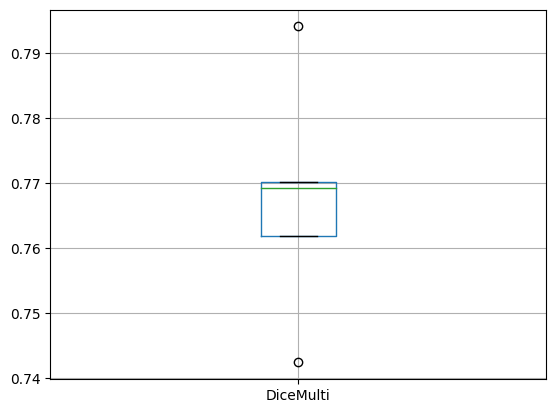

In [10]:
df = pd.DataFrame(r)
df.boxplot("DiceMulti");

In [11]:
print(
    df["DiceMulti"].mean(),
    df["DiceMulti"].std()
)

0.7675332563806448 0.018517500009897936
